In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Data/gold_futures_ohlcv.csv', parse_dates=['ts_event'])
df["ts_event"] = pd.to_datetime(df["ts_event"]).dt.tz_convert('America/New_York') # Ensure it's UTC

In [4]:
# filter for vanilla futures contracts
single_contract_filter = (df["symbol"].str.len() == 4)
fdf = df[single_contract_filter].copy()

In [5]:
future_month_map = {
    'F': 1, 'G': 2, 'H': 3, 'J': 4, 'K': 5, 'M': 6,
    'N': 7, 'Q': 8, 'U': 9, 'V': 10, 'X': 11, 'Z': 12
}

In [6]:
# function to determine contract year
def get_contract_year(row):
    contract_year_first_digit = int(row["symbol"][3])
    curr_year = row['ts_event'].year
    if contract_year_first_digit < curr_year % 10:
        contract_year = math.ceil(curr_year / 10) * 10 + contract_year_first_digit
    else:
        contract_year = math.floor(curr_year / 10) * 10 + contract_year_first_digit
    return contract_year

fdf["contract_year"] = fdf.apply(get_contract_year, axis=1)
fdf["contract_month"] = fdf.apply(lambda row: future_month_map[row['symbol'][2]], axis=1)

In [7]:
# function to determine expiry length
def get_expiry_length(row):
    month = future_month_map[row['symbol'][2]]
    year = row["contract_year"]
    # Calculate the difference in months
    return (year - row['ts_event'].year) * 12 + month - row['ts_event'].month

fdf["expiry_length"] = fdf.apply(get_expiry_length, axis=1)


In [8]:
# trim df to only front month and second month
fm_df = fdf[fdf["expiry_length"] <= 1].copy()

In [10]:
DAYS_BEFORE_EXPIRY = 3

# Function to calculate the roll date
def get_roll_date(row):
    year = row["contract_year"]
    month = row["contract_month"]
    # Get all business days in the contract month
    # Using a fixed day like 28 to be safe for all months
    end_of_month = pd.to_datetime(f"{year}-{month:02d}-01") + pd.offsets.MonthEnd(0)
    bdays = pd.bdate_range(start=f"{year}-{month:02d}-01", end=end_of_month)
    # The roll date is 3 days before the 3rd to last business day
    roll_date = bdays[-3] - pd.Timedelta(days=DAYS_BEFORE_EXPIRY)
    if roll_date.weekday() == 5: # If it's a Saturday
        roll_date = roll_date - pd.Timedelta(days=1)
    return roll_date

fm_df['contract_roll_date'] = fm_df.apply(get_roll_date, axis=1)
fm_df['contract_roll_date'] = pd.to_datetime(fm_df['contract_roll_date']).dt.tz_localize('America/New_York') # standardize

In [11]:
# create roll date marker
fm_df['roll_date_marker'] = fm_df.apply(lambda row: row['ts_event'].date() == row['contract_roll_date'].date(), axis=1)
fm_df['roll_date_marker'] = fm_df['roll_date_marker'] & (fm_df['expiry_length'] == 0)

In [12]:
# make ts event index
fm_df = fm_df.set_index('ts_event', inplace=False)

In [13]:
# split into front month and second month
frdf = fm_df[fm_df["expiry_length"] == 0].copy()
sdf = fm_df[fm_df["expiry_length"] == 1].copy()

In [20]:
# determine roll spread 
roll_dates = frdf[frdf['roll_date_marker']].index
sdf.loc[roll_dates, 'spread'] = sdf.loc[roll_dates, "open"].shift(-1) - frdf.loc[roll_dates, 'close']

In [21]:
# split into pre roll front month and post roll second month
adj_frdf = frdf[frdf.index < frdf['contract_roll_date']].copy()

# need to align because second month df doesn't have first month expiration date info
common_idx = frdf.index.intersection(sdf.index)
sdf.loc[common_idx, 'fm_roll_date'] = frdf.loc[common_idx, 'contract_roll_date'].copy()
adj_sdf = sdf[sdf.index >= sdf['fm_roll_date']].copy()

In [22]:
# combine the dataframes
data = pd.concat([adj_frdf, adj_sdf], axis=0).sort_index()

In [23]:
# adj for roll
data.loc[data['spread'].isna(), 'spread'] = 0
roll_adj = data['spread'][::-1].cumsum()[::-1]
# shift forward 
roll_adj = roll_adj[1:]
roll_adj = np.append(roll_adj, 0) 
data["adj_close"] = data['close'] + roll_adj

In [27]:
data.loc[data.index[-30:], 'close':]

,close,volume,symbol,contract_year,contract_month,expiry_length,contract_roll_date,roll_date_marker,spread,fm_roll_date,adj_close
ts_event,,,,,,,,,,,
2025-06-14 20:00:00-04:00,3442.0,1,GCM5,2025,6,0,2025-06-23 00:00:00-04:00,False,0.0,NaT,3442.0
2025-06-15 20:00:00-04:00,3385.4,32,GCM5,2025,6,0,2025-06-23 00:00:00-04:00,False,0.0,NaT,3385.4
2025-06-16 20:00:00-04:00,3388.5,18,GCM5,2025,6,0,2025-06-23 00:00:00-04:00,False,0.0,NaT,3388.5
2025-06-17 20:00:00-04:00,3365.1,38,GCM5,2025,6,0,2025-06-23 00:00:00-04:00,False,0.0,NaT,3365.1
2025-06-18 20:00:00-04:00,3364.7,16,GCM5,2025,6,0,2025-06-23 00:00:00-04:00,False,0.0,NaT,3364.7
2025-06-19 20:00:00-04:00,3363.2,84,GCM5,2025,6,0,2025-06-23 00:00:00-04:00,False,0.0,NaT,3363.2
2025-06-22 20:00:00-04:00,3358.0,19,GCM5,2025,6,0,2025-06-23 00:00:00-04:00,False,0.0,NaT,3358.0
2025-06-23 20:00:00-04:00,3324.6,1219,GCN5,2025,7,1,2025-07-25 00:00:00-04:00,False,0.0,2025-06-23 00:00:00-04:00,3324.6
2025-06-24 20:00:00-04:00,3339.5,505,GCN5,2025,7,1,2025-07-25 00:00:00-04:00,False,0.0,2025-06-23 00:00:00-04:00,3339.5


<Axes: xlabel='ts_event'>

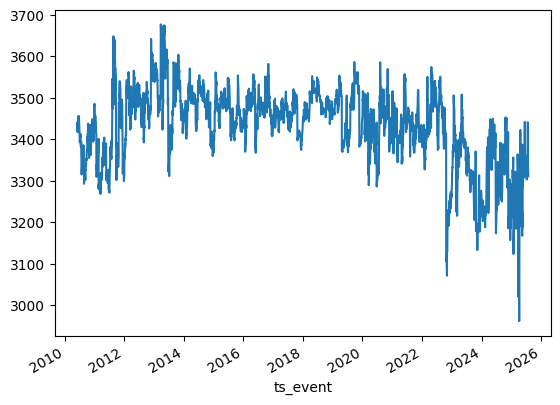

In [24]:
data["adj_close"].plot()

In [189]:
data.tail(30)

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol,contract_year,contract_month,expiry_length,contract_roll_date,roll_date_marker,spread,fm_roll_date,adj_close
ts_event,,,,,,,,,,,,,,,,,
2025-06-16 00:00:00+00:00,35,1,287,3438.2,3438.2,3385.4,3385.4,32,GCM5,2025,6,0,2025-06-23 00:00:00+00:00,False,0.0,NaT,3378.8
2025-06-17 00:00:00+00:00,35,1,287,3398.3,3398.3,3376.1,3388.5,18,GCM5,2025,6,0,2025-06-23 00:00:00+00:00,False,0.0,NaT,3381.9
2025-06-18 00:00:00+00:00,35,1,287,3385.3,3391.9,3365.1,3365.1,38,GCM5,2025,6,0,2025-06-23 00:00:00+00:00,False,0.0,NaT,3358.5
2025-06-19 00:00:00+00:00,35,1,287,3350.0,3372.9,3350.0,3364.7,16,GCM5,2025,6,0,2025-06-23 00:00:00+00:00,False,0.0,NaT,3358.1
2025-06-20 00:00:00+00:00,35,1,287,3366.9,3372.8,3341.0,3363.2,84,GCM5,2025,6,0,2025-06-23 00:00:00+00:00,False,0.0,NaT,3356.6
2025-06-23 00:00:00+00:00,35,1,42020775,3373.9,3395.4,3342.0,3342.0,2906,GCN5,2025,7,1,2025-07-25 00:00:00+00:00,False,-16.0,2025-06-23 00:00:00+00:00,3351.4
2025-06-24 00:00:00+00:00,35,1,42020775,3336.3,3355.2,3296.4,3324.6,1219,GCN5,2025,7,1,2025-07-25 00:00:00+00:00,False,0.0,2025-06-23 00:00:00+00:00,3334.0
2025-06-25 00:00:00+00:00,35,1,42020775,3328.0,3339.5,3312.0,3339.5,505,GCN5,2025,7,1,2025-07-25 00:00:00+00:00,False,0.0,2025-06-23 00:00:00+00:00,3348.9
2025-06-26 00:00:00+00:00,35,1,42020775,3335.3,3349.0,3309.2,3330.0,735,GCN5,2025,7,1,2025-07-25 00:00:00+00:00,False,0.0,2025-06-23 00:00:00+00:00,3339.4
